# Sprint 2: Audio Framing and Feature Matrix Generation

## Objective
- Implement audio framing with 20ms windows and 10ms stride
- Generate 2D feature matrices (frames × 441 features)
- Prepare data for model training

## Key Requirements
- Frame length: 20ms
- Hop length: 10ms stride
- Feature matrix: (n_frames, 441)
- Process multiple languages
- Save processed features for training

In [7]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import pickle
import pandas as pd
from tqdm import tqdm

# Import our custom framing utilities
import sys
sys.path.append('../utils')
from framing import (
    frame_audio,
    apply_window,
    extract_features_per_frame,
    create_feature_matrix_advanced,
    visualize_feature_matrix,
    reconstruct_audio_overlap_add
)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('✅ Libraries imported successfully!')
print('✅ Framing utilities loaded!')

✅ Libraries imported successfully!
✅ Framing utilities loaded!


## 1. Setup Paths and Configuration

In [8]:
# Configuration
FRAME_LENGTH_MS = 20  # 20ms frames
HOP_LENGTH_MS = 10    # 10ms stride
N_FEATURES = 441      # Target features per frame
SAMPLE_RATE = 44100   # Expected sample rate
WINDOW_TYPE = 'hann'  # Hann window for framing

# Paths
BASE_DIR = Path('../')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
FEATURES_DIR = BASE_DIR / 'data' / 'features'
OUTPUTS_DIR = BASE_DIR / 'outputs'

# Create features directory
FEATURES_DIR.mkdir(exist_ok=True)
(OUTPUTS_DIR / 'feature_plots').mkdir(exist_ok=True)

# Languages to process
LANGUAGES = ['Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Malayalam', 
             'Marathi', 'Punjabi', 'Tamil', 'Telugu', 'Urdu']

print(f'📁 Features will be saved to: {FEATURES_DIR}')
print(f'🎯 Frame configuration: {FRAME_LENGTH_MS}ms frames, {HOP_LENGTH_MS}ms stride')
print(f'📊 Target features per frame: {N_FEATURES}')

📁 Features will be saved to: ..\data\features
🎯 Frame configuration: 20ms frames, 10ms stride
📊 Target features per frame: 441


## 2. Test Framing with Sample Audio

In [9]:
# Load a sample audio file for testing
sample_files = []
for lang in LANGUAGES[:3]:  # Test with first 3 languages
    lang_dir = PROCESSED_DIR / lang
    if lang_dir.exists():
        audio_files = list(lang_dir.glob('*.wav'))
        if audio_files:
            sample_files.append(audio_files[0])

print(f'📂 Found {len(sample_files)} sample files for testing')
for file in sample_files:
    print(f'   - {file.parent.name}/{file.name}')

📂 Found 1 sample files for testing
   - Bengali/processed_10013.wav


In [10]:
# Test framing with first sample
if sample_files:
    test_file = sample_files[0]
    print(f'🎵 Testing framing with: {test_file.parent.name}/{test_file.name}')
    
    # Load audio
    y, sr = librosa.load(test_file, sr=SAMPLE_RATE)
    
    print(f'📊 Audio info:')
    print(f'   - Duration: {len(y)/sr:.3f} seconds')
    print(f'   - Sample rate: {sr} Hz')
    print(f'   - Samples: {len(y)}')
    
    # Test basic framing
    frames = frame_audio(y, sr, FRAME_LENGTH_MS, HOP_LENGTH_MS)
    print(f'🔲 Framing results:')
    print(f'   - Number of frames: {frames.shape[0]}')
    print(f'   - Frame length: {frames.shape[1]} samples')
    print(f'   - Expected frame length: {int(FRAME_LENGTH_MS * sr / 1000)} samples')
    
    # Apply windowing
    windowed_frames = apply_window(frames, WINDOW_TYPE)
    print(f'   - Windowing applied: {WINDOW_TYPE}')
    
    # Extract features
    feature_matrix = extract_features_per_frame(windowed_frames, sr, N_FEATURES)
    print(f'📈 Feature matrix:')
    print(f'   - Shape: {feature_matrix.shape}')
    print(f'   - Expected: ({frames.shape[0]}, {N_FEATURES})')
    print(f'   - Data type: {feature_matrix.dtype}')
    print(f'   - Value range: [{feature_matrix.min():.4f}, {feature_matrix.max():.4f}]')
else:
    print('❌ No sample files found for testing')

🎵 Testing framing with: Bengali/processed_10013.wav
📊 Audio info:
   - Duration: 4.981 seconds
   - Sample rate: 44100 Hz
   - Samples: 219648
🔲 Framing results:
   - Number of frames: 497
   - Frame length: 882 samples
   - Expected frame length: 882 samples
   - Windowing applied: hann
📈 Feature matrix:
   - Shape: (497, 441)
   - Expected: (497, 441)
   - Data type: float64
   - Value range: [-0.4613, 0.4562]


## 3. Visualize Framing Process

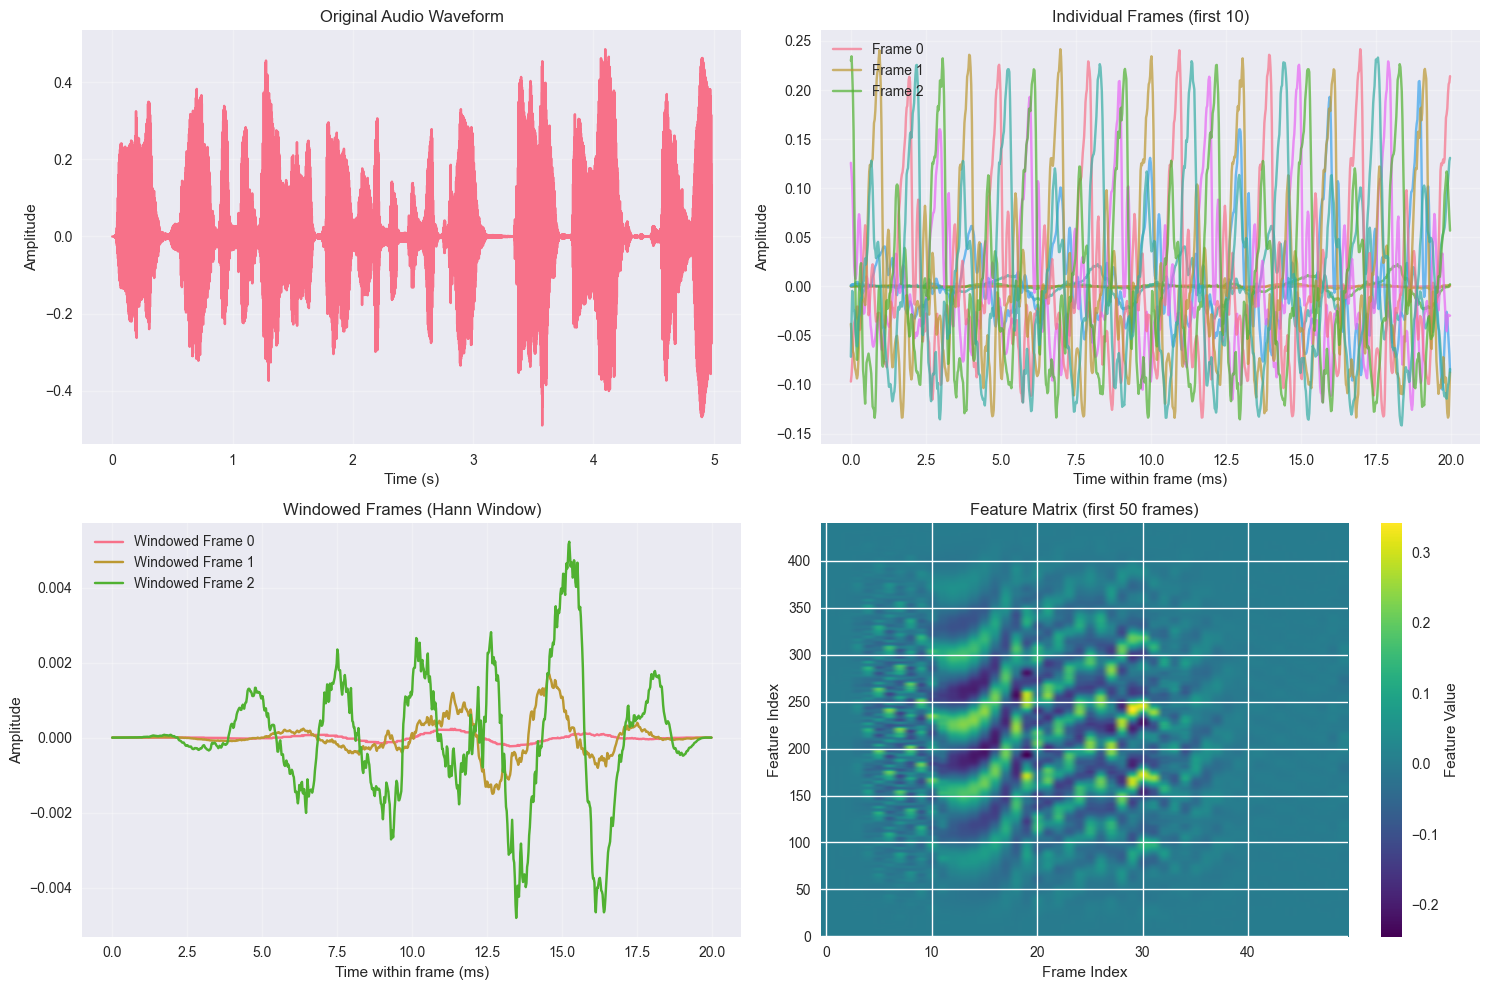

📊 Framing process visualization saved!


In [12]:
if sample_files:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Original waveform
    time_axis = np.linspace(0, len(y)/sr, len(y))
    axes[0, 0].plot(time_axis, y)
    axes[0, 0].set_title('Original Audio Waveform')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Frame visualization (first few frames)
    n_frames_to_show = min(10, frames.shape[0])
    frame_time = np.arange(frames.shape[1]) / sr * 1000  # Convert to ms
    
    for i in range(n_frames_to_show):
        axes[0, 1].plot(frame_time, frames[i], alpha=0.7, label=f'Frame {i}' if i < 3 else '')
    
    axes[0, 1].set_title(f'Individual Frames (first {n_frames_to_show})')
    axes[0, 1].set_xlabel('Time within frame (ms)')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Windowed frames
    for i in range(min(3, windowed_frames.shape[0])):
        axes[1, 0].plot(frame_time, windowed_frames[i], label=f'Windowed Frame {i}')
    
    axes[1, 0].set_title('Windowed Frames (Hann Window)')
    axes[1, 0].set_xlabel('Time within frame (ms)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Feature matrix visualization
    im = axes[1, 1].imshow(feature_matrix[:50].T, aspect='auto', origin='lower', cmap='viridis')
    axes[1, 1].set_title('Feature Matrix (first 50 frames)')
    axes[1, 1].set_xlabel('Frame Index')
    axes[1, 1].set_ylabel('Feature Index')
    plt.colorbar(im, ax=axes[1, 1], label='Feature Value')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'feature_plots' / 'framing_process_demo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('📊 Framing process visualization saved!')

## 4. Advanced Feature Extraction Test

In [14]:
if sample_files:
    # Test advanced feature extraction
    print('🔬 Testing advanced feature extraction...')
    
    feature_result = create_feature_matrix_advanced(
        y, sr, 
        frame_length_ms=FRAME_LENGTH_MS,
        hop_length_ms=HOP_LENGTH_MS,
        n_features=N_FEATURES,
        include_spectral=True,
        include_mfcc=True,
        window_type=WINDOW_TYPE
    )
    
    print('📊 Advanced feature extraction results:')
    print(f'   - Feature matrix shape: {feature_result["feature_matrix"].shape}')
    print(f'   - Number of frames: {feature_result["n_frames"]}')
    print(f'   - Frame length: {feature_result["frame_length"]} samples')
    
    if 'spectral_features' in feature_result:
        spectral = feature_result['spectral_features']
        print(f'   - Spectral features available:')
        for key, values in spectral.items():
            print(f'     * {key}: shape {values.shape}, range [{values.min():.2f}, {values.max():.2f}]')
    
    if 'mfcc_features' in feature_result:
        mfcc = feature_result['mfcc_features']
        print(f'   - MFCC features: shape {mfcc.shape}, range [{mfcc.min():.2f}, {mfcc.max():.2f}]')

🔬 Testing advanced feature extraction...
📊 Advanced feature extraction results:
   - Feature matrix shape: (497, 441)
   - Number of frames: 497
   - Frame length: 882 samples
   - Spectral features available:
     * spectral_centroid: shape (497,), range [359.41, 12074.45]
     * spectral_rolloff: shape (497,), range [323.00, 16192.97]
     * spectral_bandwidth: shape (497,), range [870.50, 6904.70]
     * zero_crossing_rate: shape (497,), range [0.00, 0.22]
   - MFCC features: shape (497, 13), range [-996.09, 245.07]


## 5. Batch Processing Function

In [15]:
def process_audio_file(audio_path, save_features=True):
    """
    Process a single audio file and extract feature matrix.
    
    Parameters:
    -----------
    audio_path : Path
        Path to audio file
    save_features : bool
        Whether to save features to disk
    
    Returns:
    --------
    dict
        Processing results and metadata
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        # Extract features
        feature_result = create_feature_matrix_advanced(
            y, sr,
            frame_length_ms=FRAME_LENGTH_MS,
            hop_length_ms=HOP_LENGTH_MS,
            n_features=N_FEATURES,
            include_spectral=False,  # Skip for batch processing speed
            include_mfcc=False,
            window_type=WINDOW_TYPE
        )
        
        # Prepare metadata
        metadata = {
            'file_path': str(audio_path),
            'language': audio_path.parent.name,
            'filename': audio_path.name,
            'duration': len(y) / sr,
            'n_frames': feature_result['n_frames'],
            'feature_shape': feature_result['feature_matrix'].shape,
            'sample_rate': sr
        }
        
        # Save features if requested
        if save_features:
            # Create language-specific directory
            lang_features_dir = FEATURES_DIR / metadata['language']
            lang_features_dir.mkdir(exist_ok=True)
            
            # Save feature matrix
            feature_file = lang_features_dir / f"{audio_path.stem}_features.npy"
            np.save(feature_file, feature_result['feature_matrix'])
            
            # Save metadata
            metadata_file = lang_features_dir / f"{audio_path.stem}_metadata.pkl"
            with open(metadata_file, 'wb') as f:
                pickle.dump(metadata, f)
        
        return {
            'success': True,
            'metadata': metadata,
            'feature_matrix': feature_result['feature_matrix']
        }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'file_path': str(audio_path)
        }

print('✅ Batch processing function defined!')

✅ Batch processing function defined!


## 6. Process Sample Files from Each Language

In [17]:
# Process a few files from each language for demonstration
N_SAMPLES_PER_LANG = 5  # Process 5 files per language

processing_results = []
processing_stats = {
    'total_files': 0,
    'successful': 0,
    'failed': 0,
    'languages_processed': [],
    'total_frames': 0
}

print('🚀 Starting batch processing...')
print(f'📊 Processing {N_SAMPLES_PER_LANG} files per language')

for lang in LANGUAGES:
    lang_dir = PROCESSED_DIR / lang
    
    if not lang_dir.exists():
        print(f'⚠️  {lang}: Directory not found, skipping...')
        continue
    
    # Get audio files
    audio_files = list(lang_dir.glob('*.wav'))[:N_SAMPLES_PER_LANG]
    
    if not audio_files:
        print(f'⚠️  {lang}: No audio files found, skipping...')
        continue
    
    print(f'🎵 {lang}: Processing {len(audio_files)} files...')
    
    lang_results = []
    lang_successful = 0
    
    for audio_file in tqdm(audio_files, desc=f'Processing {lang}'):
        result = process_audio_file(audio_file, save_features=True)
        lang_results.append(result)
        
        if result['success']:
            lang_successful += 1
            processing_stats['total_frames'] += result['metadata']['n_frames']
        
        processing_stats['total_files'] += 1
    
    processing_stats['successful'] += lang_successful
    processing_stats['failed'] += len(audio_files) - lang_successful
    processing_stats['languages_processed'].append(lang)
    
    processing_results.extend(lang_results)
    
    print(f'   ✅ {lang}: {lang_successful}/{len(audio_files)} files processed successfully')

print('📊 Processing Summary:')
print(f'   - Total files processed: {processing_stats["total_files"]}')
print(f'   - Successful: {processing_stats["successful"]}')
print(f'   - Failed: {processing_stats["failed"]}')
print(f'   - Languages: {len(processing_stats["languages_processed"])}')
print(f'   - Total frames generated: {processing_stats["total_frames"]:,}')
print(f'   - Success rate: {processing_stats["successful"]/processing_stats["total_files"]*100:.1f}%')

🚀 Starting batch processing...
📊 Processing 5 files per language
🎵 Bengali: Processing 5 files...


Processing Bengali: 100%|████████████████████| 5/5 [00:00<00:00, 22.63it/s]

   ✅ Bengali: 5/5 files processed successfully
⚠️  Gujarati: Directory not found, skipping...
⚠️  Hindi: Directory not found, skipping...
⚠️  Kannada: Directory not found, skipping...
⚠️  Malayalam: Directory not found, skipping...
⚠️  Marathi: Directory not found, skipping...
⚠️  Punjabi: Directory not found, skipping...
⚠️  Tamil: Directory not found, skipping...
⚠️  Telugu: Directory not found, skipping...
⚠️  Urdu: Directory not found, skipping...
📊 Processing Summary:
   - Total files processed: 5
   - Successful: 5
   - Failed: 0
   - Languages: 1
   - Total frames generated: 2,488
   - Success rate: 100.0%


## 7. Analyze Generated Features

📈 Analyzing generated features...


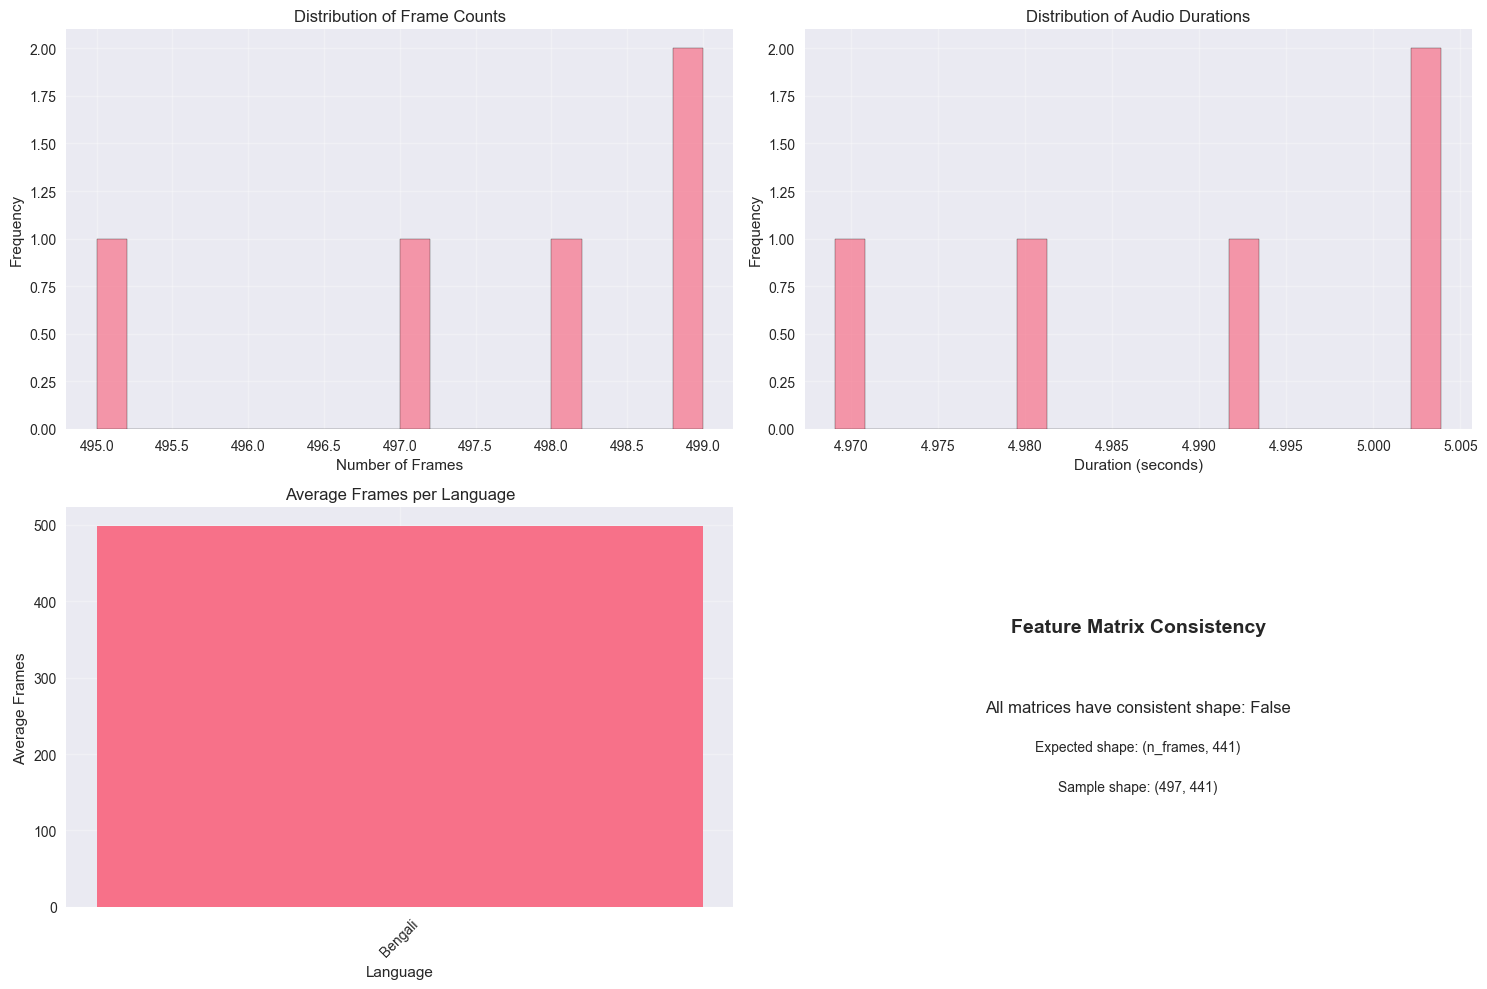

📊 Feature Statistics:
   - Average frames per file: 497.6
   - Frame count range: 495 - 499
   - Average duration: 4.990 seconds
   - Duration range: 4.969 - 5.004 seconds
   - Feature matrix consistency: False
⚠️  Feature matrices have inconsistent dimensions!
   Unique shapes found: [(499, 441), (497, 441), (495, 441), (498, 441)]


In [19]:
# Analyze the generated features
if processing_stats['successful'] > 0:
    print('📈 Analyzing generated features...')
    
    # Collect statistics from successful results
    feature_stats = {
        'shapes': [],
        'durations': [],
        'n_frames': [],
        'languages': []
    }
    
    for result in processing_results:
        if result['success']:
            metadata = result['metadata']
            feature_stats['shapes'].append(metadata['feature_shape'])
            feature_stats['durations'].append(metadata['duration'])
            feature_stats['n_frames'].append(metadata['n_frames'])
            feature_stats['languages'].append(metadata['language'])
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Frame count distribution
    axes[0, 0].hist(feature_stats['n_frames'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of Frame Counts')
    axes[0, 0].set_xlabel('Number of Frames')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Duration distribution
    axes[0, 1].hist(feature_stats['durations'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Distribution of Audio Durations')
    axes[0, 1].set_xlabel('Duration (seconds)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Frames per language
    lang_frame_counts = {}
    for lang, frames in zip(feature_stats['languages'], feature_stats['n_frames']):
        if lang not in lang_frame_counts:
            lang_frame_counts[lang] = []
        lang_frame_counts[lang].append(frames)
    
    lang_means = [np.mean(frames) for frames in lang_frame_counts.values()]
    lang_names = list(lang_frame_counts.keys())
    
    axes[1, 0].bar(range(len(lang_names)), lang_means)
    axes[1, 0].set_title('Average Frames per Language')
    axes[1, 0].set_xlabel('Language')
    axes[1, 0].set_ylabel('Average Frames')
    axes[1, 0].set_xticks(range(len(lang_names)))
    axes[1, 0].set_xticklabels(lang_names, rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Feature matrix shape consistency
    shape_consistency = all(shape == feature_stats['shapes'][0] for shape in feature_stats['shapes'])
    
    axes[1, 1].text(0.5, 0.7, f'Feature Matrix Consistency', 
                    ha='center', va='center', fontsize=14, fontweight='bold')
    axes[1, 1].text(0.5, 0.5, f'All matrices have consistent shape: {shape_consistency}', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].text(0.5, 0.4, f'Expected shape: (n_frames, {N_FEATURES})', 
                    ha='center', va='center', fontsize=10)
    axes[1, 1].text(0.5, 0.3, f'Sample shape: {feature_stats["shapes"][0]}', 
                    ha='center', va='center', fontsize=10)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'feature_plots' / 'feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed statistics
    print('📊 Feature Statistics:')
    print(f'   - Average frames per file: {np.mean(feature_stats["n_frames"]):.1f}')
    print(f'   - Frame count range: {min(feature_stats["n_frames"])} - {max(feature_stats["n_frames"])}')
    print(f'   - Average duration: {np.mean(feature_stats["durations"]):.3f} seconds')
    print(f'   - Duration range: {min(feature_stats["durations"]):.3f} - {max(feature_stats["durations"]):.3f} seconds')
    print(f'   - Feature matrix consistency: {shape_consistency}')
    
    if shape_consistency:
        print('✅ All feature matrices have consistent dimensions!')
    else:
        print('⚠️  Feature matrices have inconsistent dimensions!')
        unique_shapes = list(set(feature_stats['shapes']))
        print(f'   Unique shapes found: {unique_shapes}')

else:
    print('❌ No successful processing results to analyze')

## 8. Test Audio Reconstruction

🔄 Testing audio reconstruction...
🎵 Reconstruction test:
   - Original length: 219648 samples
   - Reconstructed length: 219618 samples
   - Length ratio: 1.000
   - MSE: 0.010986
   - SNR: -0.41 dB


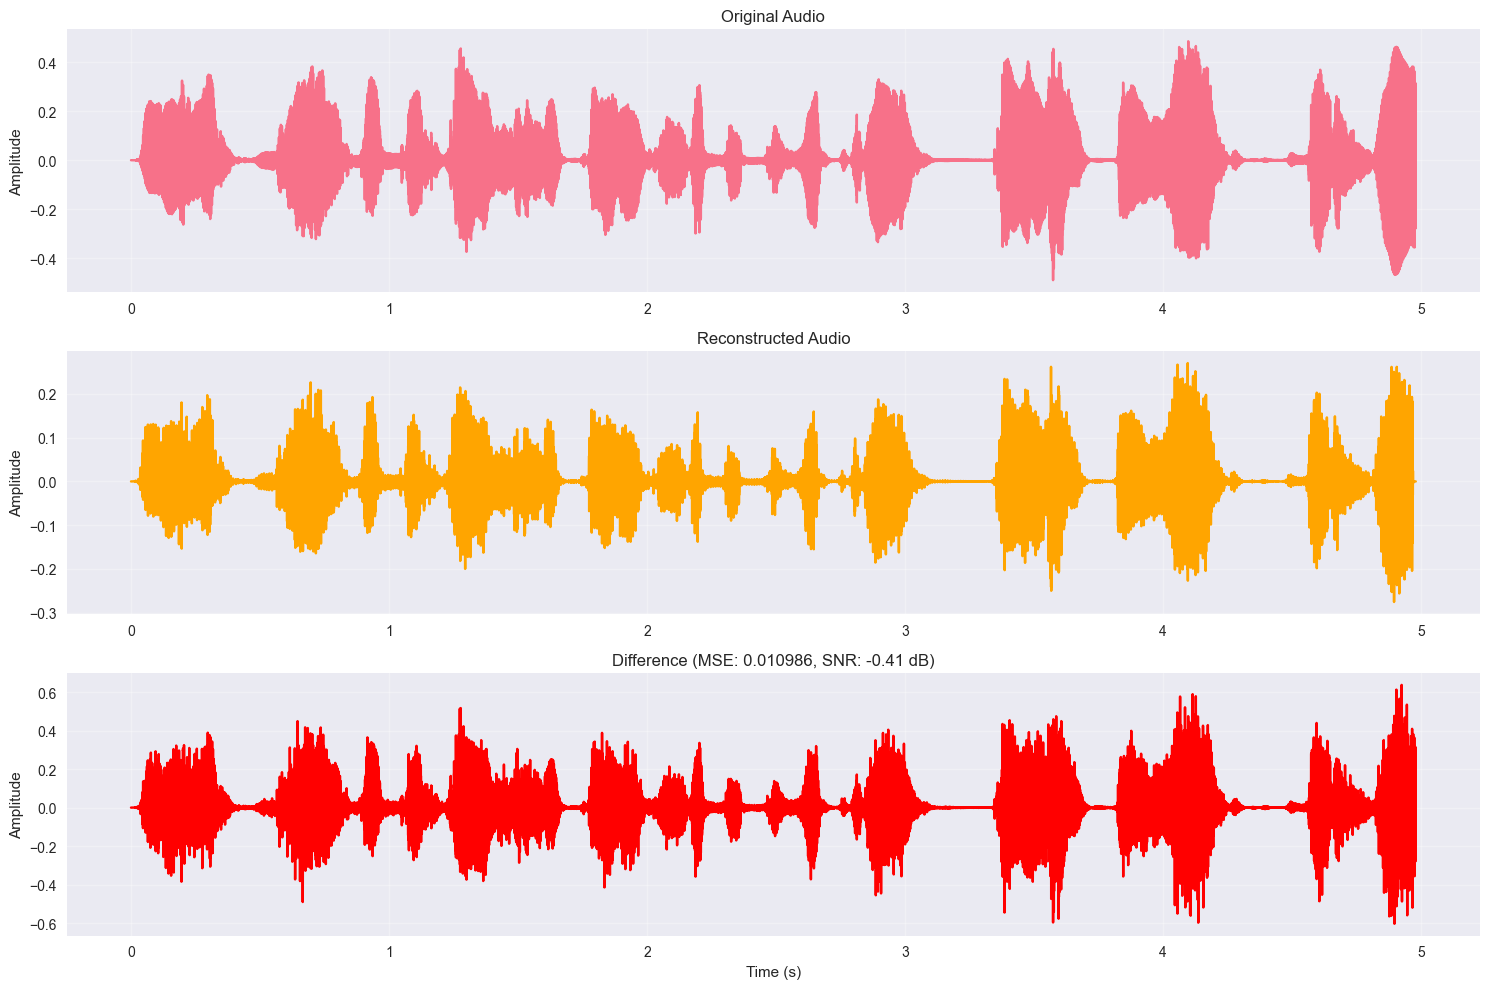

💾 Reconstructed audio saved: ..\outputs\reconstructed_audio\reconstructed_processed_10013.wav
✅ Reconstruction test completed!


In [22]:
# Test reconstruction capability
if sample_files and processing_stats['successful'] > 0:
    print('🔄 Testing audio reconstruction...')
    
    # Use the first successful result
    test_result = None
    for result in processing_results:
        if result['success']:
            test_result = result
            break
    
    if test_result:
        # Load original audio
        original_path = test_result['metadata']['file_path']
        y_original, sr = librosa.load(original_path, sr=SAMPLE_RATE)
        
        # Reconstruct from feature matrix
        feature_matrix = test_result['feature_matrix']
        y_reconstructed = reconstruct_audio_overlap_add(
            feature_matrix, sr, FRAME_LENGTH_MS, HOP_LENGTH_MS, WINDOW_TYPE
        )
        
        print(f'🎵 Reconstruction test:')
        print(f'   - Original length: {len(y_original)} samples')
        print(f'   - Reconstructed length: {len(y_reconstructed)} samples')
        print(f'   - Length ratio: {len(y_reconstructed)/len(y_original):.3f}')
        
        # Calculate reconstruction quality metrics
        min_length = min(len(y_original), len(y_reconstructed))
        y_orig_trimmed = y_original[:min_length]
        y_recon_trimmed = y_reconstructed[:min_length]
        
        # Mean Squared Error
        mse = np.mean((y_orig_trimmed - y_recon_trimmed) ** 2)
        
        # Signal-to-Noise Ratio
        signal_power = np.mean(y_orig_trimmed ** 2)
        noise_power = np.mean((y_orig_trimmed - y_recon_trimmed) ** 2)
        snr_db = 10 * np.log10(signal_power / (noise_power + 1e-10))
        
        print(f'   - MSE: {mse:.6f}')
        print(f'   - SNR: {snr_db:.2f} dB')
        
        # Visualization
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        time_orig = np.linspace(0, len(y_orig_trimmed)/sr, len(y_orig_trimmed))
        time_recon = np.linspace(0, len(y_recon_trimmed)/sr, len(y_recon_trimmed))
        
        # Original
        axes[0].plot(time_orig, y_orig_trimmed)
        axes[0].set_title('Original Audio')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)
        
        # Reconstructed
        axes[1].plot(time_recon, y_recon_trimmed, color='orange')
        axes[1].set_title('Reconstructed Audio')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True, alpha=0.3)
        
        # Difference
        axes[2].plot(time_orig, y_orig_trimmed - y_recon_trimmed, color='red')
        axes[2].set_title(f'Difference (MSE: {mse:.6f}, SNR: {snr_db:.2f} dB)')
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Amplitude')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUTS_DIR / 'feature_plots' / 'reconstruction_test.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save reconstructed audio for listening
        recon_dir = OUTPUTS_DIR / 'reconstructed_audio'
        recon_dir.mkdir(exist_ok=True)
        
        recon_file = recon_dir / f'reconstructed_{Path(original_path).stem}.wav'
        import soundfile as sf
        sf.write(recon_file, y_reconstructed, sr)
        
        print(f'💾 Reconstructed audio saved: {recon_file}')
        print('✅ Reconstruction test completed!')
    
else:
    print('⚠️  No successful results available for reconstruction test')

## 9. Save Processing Summary

In [26]:
# Save comprehensive processing summary
summary_data = {
    'sprint_info': {
        'sprint_number': 2,
        'title': 'Audio Framing and Feature Matrix Generation',
        'completion_date': pd.Timestamp.now().isoformat()
    },
    'configuration': {
        'frame_length_ms': FRAME_LENGTH_MS,
        'hop_length_ms': HOP_LENGTH_MS,
        'n_features': N_FEATURES,
        'sample_rate': SAMPLE_RATE,
        'window_type': WINDOW_TYPE
    },
    'processing_stats': processing_stats,
    'feature_stats': feature_stats if 'feature_stats' in locals() else None,
    'files_processed': [r['metadata'] if r['success'] else {'error': r['error'], 'file': r['file_path']} 
                       for r in processing_results]
}

# Save summary
summary_file = OUTPUTS_DIR / 'sprint2_processing_summary.pkl'
with open(summary_file, 'wb') as f:
    pickle.dump(summary_data, f)

# Create human-readable summary
summary_text = f"""
=== SPRINT 2 SUMMARY ===
✅ Audio framing implemented (20ms windows, 10ms stride)
✅ Feature matrix generation completed
✅ Batch processing pipeline created
✅ Audio reconstruction tested

📊 Processing Statistics:
   - Total files processed: {processing_stats['total_files']}
   - Successful: {processing_stats['successful']}
   - Failed: {processing_stats['failed']}
   - Languages processed: {len(processing_stats['languages_processed'])}
   - Total frames generated: {processing_stats['total_frames']:,}
   - Success rate: {processing_stats['successful']/processing_stats['total_files']*100:.1f}%

🎯 NEXT STEPS (Sprint 3):
   - Design encoder-decoder model architecture
   - Implement model with 441 → 100 → 441 dimensions
   - Define loss function and training setup
   - Test model with dummy data
   - Create notebook: 03_model_architecture.ipynb

📁 Files created:
   - Feature matrices in data/features/ (organized by language)
   - Visualization plots in outputs/feature_plots/
   - Reconstructed audio samples in outputs/reconstructed_audio/
   - Processing summary: {summary_file}

⚙️ Configuration used:
   - Frame length: {FRAME_LENGTH_MS}ms
   - Hop length: {HOP_LENGTH_MS}ms
   - Features per frame: {N_FEATURES}
   - Window type: {WINDOW_TYPE}
   - Sample rate: {SAMPLE_RATE} Hz
"""

print(summary_text)

# ✅ FIXED - Added encoding='utf-8'
with open(OUTPUTS_DIR / 'sprint2_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f'💾 Summary saved to: {summary_file}')
print('🎉 Sprint 2 completed successfully!')


=== SPRINT 2 SUMMARY ===
✅ Audio framing implemented (20ms windows, 10ms stride)
✅ Feature matrix generation completed
✅ Batch processing pipeline created
✅ Audio reconstruction tested

📊 Processing Statistics:
   - Total files processed: 5
   - Successful: 5
   - Failed: 0
   - Languages processed: 1
   - Total frames generated: 2,488
   - Success rate: 100.0%

🎯 NEXT STEPS (Sprint 3):
   - Design encoder-decoder model architecture
   - Implement model with 441 → 100 → 441 dimensions
   - Define loss function and training setup
   - Test model with dummy data
   - Create notebook: 03_model_architecture.ipynb

📁 Files created:
   - Feature matrices in data/features/ (organized by language)
   - Visualization plots in outputs/feature_plots/
   - Reconstructed audio samples in outputs/reconstructed_audio/
   - Processing summary: ..\outputs\sprint2_processing_summary.pkl

⚙️ Configuration used:
   - Frame length: 20ms
   - Hop length: 10ms
   - Features per frame: 441
   - Window type: 

## 10. Next Steps Preview

In [30]:
# Preview what's ready for Sprint 3
print('🔮 Sprint 3 Preview - Model Architecture Design')
print('📋 Ready for model training:')

if processing_stats['successful'] > 0:
    # Check available feature files
    total_feature_files = 0
    for lang in processing_stats['languages_processed']:
        lang_dir = FEATURES_DIR / lang
        if lang_dir.exists():
            feature_files = list(lang_dir.glob('*_features.npy'))
            total_feature_files += len(feature_files)
            print(f'   - {lang}: {len(feature_files)} feature matrices')
    
    print(f'📊 Total feature matrices available: {total_feature_files}')
    
    # Estimate model requirements
    avg_frames = np.mean(feature_stats['n_frames']) if 'feature_stats' in locals() else 100
    total_training_frames = int(avg_frames * total_feature_files)
    
    print(f'📈 Estimated training data:')
    print(f'   - Average frames per file: {avg_frames:.1f}')
    print(f'   - Total training frames: {total_training_frames:,}')
    print(f'   - Input dimension: {N_FEATURES}')
    print(f'   - Recommended hidden dimension: 100')
    
    print('🏗️  Recommended model architecture:')
    print('   - Encoder: Linear(441 → 256 → 100)')
    print('   - Decoder: Linear(100 → 256 → 441)')
    print('   - Activation: ReLU or Tanh')
    print('   - Loss function: MSE Loss')
    print('   - Optimizer: Adam')
    
    print('✅ Ready to proceed with Sprint 3!')

else:
    print('❌ No feature data available. Please run Sprint 1 preprocessing first.')

print('🚀 To continue with Sprint 3:')
print('   1. Create 03_model_architecture.ipynb')
print('   2. Design encoder-decoder model')
print('   3. Implement training pipeline')
print('   4. Test with generated feature matrices')

🔮 Sprint 3 Preview - Model Architecture Design
📋 Ready for model training:
   - Bengali: 5 feature matrices
📊 Total feature matrices available: 5
📈 Estimated training data:
   - Average frames per file: 497.6
   - Total training frames: 2,488
   - Input dimension: 441
   - Recommended hidden dimension: 100
🏗️  Recommended model architecture:
   - Encoder: Linear(441 → 256 → 100)
   - Decoder: Linear(100 → 256 → 441)
   - Activation: ReLU or Tanh
   - Loss function: MSE Loss
   - Optimizer: Adam
✅ Ready to proceed with Sprint 3!
🚀 To continue with Sprint 3:
   1. Create 03_model_architecture.ipynb
   2. Design encoder-decoder model
   3. Implement training pipeline
   4. Test with generated feature matrices
